In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import random
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

1.14.0


In [2]:
def load_imdb_sentiment_analysis_dataset(data_path, seed=123):
    """Loads the IMDb movie reviews sentiment analysis dataset.

    # Arguments
        data_path: string, path to the data directory.
        seed: int, seed for randomizer.

    # Returns
        A tuple of training and validation data.
        Number of training samples: 25000
        Number of test samples: 25000
        Number of categories: 2 (0 - negative, 1 - positive)

    # References
        Mass et al., http://www.aclweb.org/anthology/P11-1015

        Download and uncompress archive from:
        http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    """
    imdb_data_path = os.path.join(data_path, 'aclImdb')

    # Load the training data
    train_texts = []
    train_labels = []
    for category in ['pos', 'neg']:
        train_path = os.path.join(imdb_data_path, 'train', category)
        for fname in sorted(os.listdir(train_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(train_path, fname)) as f:
                    train_texts.append(f.read())
                train_labels.append(0 if category == 'neg' else 1)

    # Load the validation data.
    test_texts = []
    test_labels = []
    for category in ['pos', 'neg']:
        test_path = os.path.join(imdb_data_path, 'test', category)
        for fname in sorted(os.listdir(test_path)):
            if fname.endswith('.txt'):
                with open(os.path.join(test_path, fname)) as f:
                    test_texts.append(f.read())
                test_labels.append(0 if category == 'neg' else 1)

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

In [3]:
%matplotlib inline 

def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes

def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    #plt.figure(figsize=(100,60))
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()
    

In [4]:
train, test = load_imdb_sentiment_analysis_dataset("data/aclImdb_v1")

In [5]:
#show me the data
train

(["POSSIBLE SPOILERS<br /><br />The Spy Who Shagged Me is a muchly overrated and over-hyped sequel. International Man of Mystery came straight out of the blue. It was a lone star that few people had heard of. But it was stunningly original, had sophisticated humour and ample humour, always kept in good taste, and had a brilliant cast. The Spy Who Shagged Me was a lot more commercially advertised and hyped about.<br /><br />OK I'll admit, the first time I saw this film I thought it was very funny, but it's only after watching it two or three times that you see all the flaws. The acting was OK, but Heather Graham cannot act. Her performance didn't seem very convincing and she wasn't near as good as Liz Hurley was in the first one. Those characters who bloomed in the first one, (Scott Evil, Number 2 etc.) are thrown into the background hear and don't get many stand-alone scenes. The film is simply overrun with cameos.<br /><br />In particular, I hated the way they totally disregarded some

In [6]:
#show me one sample
train[0][1]

'The long list of "big" names in this flick (including the ubiquitous John Mills) didn\'t bowl me over to the extent that I couldn\'t judge the film on its actual merits. It is FULL of stereotypes, caricatures, and standard, set scenes, from the humble air-ace hero to the loud-mouthed yank flyer. The music track was such that at one point, about an hour before the end, I thought the film was over: loud, rising crescendo, grand flourish and finish then silence, but then the movie continued! I found no real storyline, haphazard writing, but smartly-pressed uniforms and the pretty Jean Simmons (pre-nose job) with a rousing little ditty. I cannot say that this picture has any of the ingredients which make a film great. I found it maudlin, mawkish and minor.'

In [7]:
#show me this last sample's label
train[1][1]

0

In [8]:
#size of the data
print("train: ", len(train[0]))
print("test: ", len(test[0]))

train:  25000
test:  25000


In [9]:
ratio = len(train[0])/get_num_words_per_sample(train[0])
ratio

143.67816091954023

In [10]:
get_num_words_per_sample(test[0])

172.0

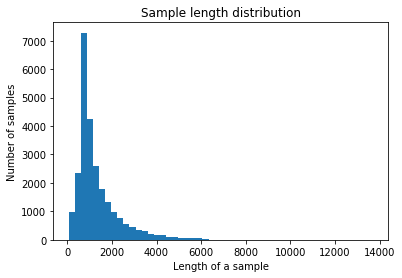

In [11]:
plot_sample_length_distribution(train[0])

In [12]:
words = []
for s in train[0]:
    list_words = s.split()
    for l in list_words:
        l = l.lower()
        words.append(l)

len(words)

5844680

In [13]:
pdwords = pd.Series(words)
type(pdwords)

pandas.core.series.Series

plt.hist(words, 10)
plt.xlabel('Words')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [14]:
pdwords = pdwords.value_counts()
pdwords

the                     322198
a                       159953
and                     158572
of                      144462
to                      133967
is                      104171
in                       90527
i                        70480
this                     69714
that                     66292
it                       65505
/><br                    50935
was                      47024
as                       45102
for                      42843
with                     42729
but                      39764
on                       31619
movie                    30887
his                      29059
are                      28743
not                      28597
film                     27777
you                      27564
have                     27344
he                       26177
be                       25691
at                       22731
one                      22480
by                       21976
                         ...  
horse--literally.            1
grey),  

In [15]:
pdwords[:50]

the      322198
a        159953
and      158572
of       144462
to       133967
is       104171
in        90527
i         70480
this      69714
that      66292
it        65505
/><br     50935
was       47024
as        45102
for       42843
with      42729
but       39764
on        31619
movie     30887
his       29059
are       28743
not       28597
film      27777
you       27564
have      27344
he        26177
be        25691
at        22731
one       22480
by        21976
an        21240
they      20624
from      19934
all       19740
who       19407
like      18779
so        18099
just      17309
or        16769
has       16570
her       16540
about     16486
it's      15970
some      15280
if        15189
out       14510
what      14055
very      13633
when      13609
more      13170
dtype: int64

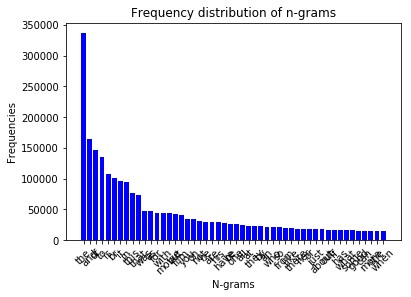

In [16]:
plot_frequency_distribution_of_ngrams(train[0],ngram_range=(4,2))

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    """Vectorizes texts as n-gram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of unigrams + bigrams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': NGRAM_RANGE,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

In [18]:
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.preprocessing import text

# Vectorization parameters
# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500

def sequence_vectorize(train_texts, val_texts):
    """Vectorizes texts as sequence vectors.

    1 text = 1 sequence vector with fixed length.

    # Arguments
        train_texts: list, training text strings.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val, word_index: vectorized training and validation
            texts and word index dictionary.
    """
    # Create vocabulary with training texts.
    tokenizer = text.Tokenizer(num_words=TOP_K)
    tokenizer.fit_on_texts(train_texts)

    # Vectorize training and validation texts.
    x_train = tokenizer.texts_to_sequences(train_texts)
    x_val = tokenizer.texts_to_sequences(val_texts)

    # Get max sequence length.
    max_length = len(max(x_train, key=len))
    if max_length > MAX_SEQUENCE_LENGTH:
        max_length = MAX_SEQUENCE_LENGTH

    # Fix sequence length to max value. Sequences shorter than the length are
    # padded in the beginning and sequences longer are truncated
    # at the beginning.
    x_train = sequence.pad_sequences(x_train, maxlen=max_length)
    x_val = sequence.pad_sequences(x_val, maxlen=max_length)
    return x_train, x_val, tokenizer.word_index

In [19]:
def _get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [20]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

In [21]:
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers

from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import SeparableConv1D
from tensorflow.python.keras.layers import MaxPooling1D
from tensorflow.python.keras.layers import GlobalAveragePooling1D

def sepcnn_model(blocks,
                 filters,
                 kernel_size,
                 embedding_dim,
                 dropout_rate,
                 pool_size,
                 input_shape,
                 num_classes,
                 num_features,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    op_units, op_activation = _get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0],
                            weights=[embedding_matrix],
                            trainable=is_embedding_trainable))
    else:
        model.add(Embedding(input_dim=num_features,
                            output_dim=embedding_dim,
                            input_length=input_shape[0]))

    for _ in range(blocks-1):
        model.add(Dropout(rate=dropout_rate))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(SeparableConv1D(filters=filters,
                                  kernel_size=kernel_size,
                                  activation='relu',
                                  bias_initializer='random_uniform',
                                  depthwise_initializer='random_uniform',
                                  padding='same'))
        model.add(MaxPooling1D(pool_size=pool_size))

    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(SeparableConv1D(filters=filters * 2,
                              kernel_size=kernel_size,
                              activation='relu',
                              bias_initializer='random_uniform',
                              depthwise_initializer='random_uniform',
                              padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(op_units, activation=op_activation))
    return model

In [33]:
def train_ngram_model(data,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Verify that validation labels are in the same range as training labels.
    num_classes = get_num_classes(train_labels)
    unexpected_labels = [v for v in val_labels if v not in range(num_classes)]
    if len(unexpected_labels):
        raise ValueError('Unexpected label values found in the validation set:'
                         ' {unexpected_labels}. Please make sure that the '
                         'labels in the validation set are in the same range '
                         'as training labels.'.format(
                             unexpected_labels=unexpected_labels))

    # Vectorize texts.
    x_train, x_val = ngram_vectorize(
        train_texts, train_labels, val_texts)

    # Create model instance.
    model = mlp_model(layers=layers,
                                  units=units,
                                  dropout_rate=dropout_rate,
                                  input_shape=x_train.shape[1:],
                                  num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        loss = 'sparse_categorical_crossentropy'
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=2)]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('IMDb_mlp_model.h5')
    #return history['val_acc'][-1], history['val_loss'][-1]
    return model

In [23]:
data = load_imdb_sentiment_analysis_dataset("data/aclImdb_v1")


In [34]:
model = train_ngram_model(data)

/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


Train on 25000 samples, validate on 25000 samples
Epoch 1/1000
25000/25000 - 10s - loss: 0.4758 - acc: 0.8619 - val_loss: 0.3271 - val_acc: 0.8850
Epoch 2/1000
25000/25000 - 11s - loss: 0.2359 - acc: 0.9193 - val_loss: 0.2529 - val_acc: 0.9017
Epoch 3/1000
25000/25000 - 10s - loss: 0.1703 - acc: 0.9409 - val_loss: 0.2331 - val_acc: 0.9066
Epoch 4/1000
25000/25000 - 10s - loss: 0.1352 - acc: 0.9538 - val_loss: 0.2340 - val_acc: 0.9048
Epoch 5/1000
25000/25000 - 10s - loss: 0.1120 - acc: 0.9630 - val_loss: 0.2327 - val_acc: 0.9047
Epoch 6/1000
25000/25000 - 10s - loss: 0.0941 - acc: 0.9698 - val_loss: 0.2378 - val_acc: 0.9037
Epoch 7/1000
25000/25000 - 10s - loss: 0.0798 - acc: 0.9749 - val_loss: 0.2502 - val_acc: 0.8986
Validation accuracy: 0.8985999822616577, loss: 0.25022677219867706


In [30]:
test_data = test[0]
test_labels = test[1]

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_2 (Dropout)          (None, 20000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1280064   
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________
